In [1]:
from DLtools.Trial_evaluation_rec import real_eva_error
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#-------------------------------#
import pywt
from scipy.stats import pearsonr

In [3]:
#Split XY
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        # past= DWT_seq_tran(past)
        # future = DWT_seq_tran(future)
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

##--------------added Wavelet ---------------##
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            # name:signal,
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    global syn
    syn = syn+'[wav]'
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
def inverse_WT(coeffs_list):
    wav=list()
    for i in range(coeffs_list[0].shape[0]):
        iwave = pywt.iswt([coeff[i,:] for coeff in coeffs_list],'db4')
        wav.append(iwave)
    return np.array(wav)

In [5]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [7]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

# Split triantest

In [9]:
data_mar

,CPY012_wl,PIN004_wl,WAN003_wl,CPY006_wl,WAN005_wl,NAN009_wl,YOM012_wl,BKK013_wl,DNP028_press,BKK021_wl
date,,,,,,,,,,
2014-10-01 00:00:00,1.473333,41.020000,172.339996,7.330000,231.861664,181.173340,47.641998,2.232000,937.799988,1.854000
2014-10-01 01:00:00,1.425000,41.038666,172.345993,7.330000,231.846664,181.145004,47.631668,2.230000,937.799988,1.836667
2014-10-01 02:00:00,1.360000,41.057335,172.352005,7.330000,231.839996,181.130005,47.619999,2.226667,936.710022,1.816667
2014-10-01 03:00:00,1.286667,41.076000,172.358002,7.330000,231.838806,181.113800,47.604801,2.230000,936.710022,1.810000
2014-10-01 04:00:00,1.215000,41.094666,172.363998,7.330000,231.837601,181.097595,47.589600,2.228333,936.710022,1.794444
...,...,...,...,...,...,...,...,...,...,...
2017-10-01 19:00:00,2.375000,41.525002,173.363327,11.150000,233.133331,180.880005,48.803333,2.811667,932.369995,1.371667
2017-10-01 20:00:00,2.375000,41.518333,173.375000,11.150000,233.143326,180.880005,48.808334,2.815000,933.460022,1.361667
2017-10-01 21:00:00,2.375000,41.508335,173.391663,11.145000,233.191666,180.880005,48.813332,2.811667,934.539978,1.360000


In [95]:
pywt.swt_max_level(data_mar.shape[0])

3

In [135]:
signal = data_mar['CPY012_wl']

#-------------------------------
coeff = np.array(pywt.swt(signal,'db4',level=1))
coeff.shape

(1, 2, 26328)

In [133]:
cA,cD2 = coeff[0,0,:],coeff[0,1,:]
cD1 = coeff[1,1,:]

In [134]:
coeff_next = np.array(pywt.swt(cA,'db4',level=2))

In [123]:
cD = np.sum([cD1.reshape(-1,1),cD2.reshape(-1,1)],axis=0)
cD=cD.reshape(-1,26328)
len(cD[0])

26328

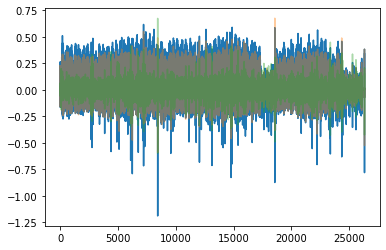

In [124]:
plt.plot(cD[0])
plt.plot(cD2,alpha=0.4)
plt.plot(cD1,alpha=0.4)


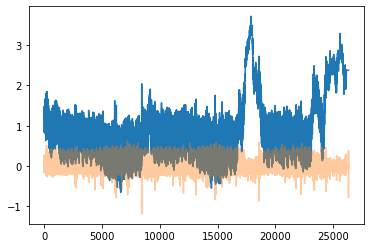

In [128]:
plt.plot(signal.values)
plt.plot(pywt.iswt([cD[0]],'db4'),alpha=0.4)
#plt.plot(pywt.iswt([cA,cD2,cD1],'db4'),alpha=0.4)

In [131]:
corr, _ = pearsonr(signal, cD[0])
print('Pearsons correlation: %.3f' % corr)


corr, _ = pearsonr(signal, pywt.iswt([cD[0]],'db4'))
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.188
Pearsons correlation: -0.188


In [156]:
for col in data_mar.columns:
    print(col)
    for lv in range(1,4):
        signal = data_mar[col]
        coeff = np.array(pywt.swt(signal,'db4',level=lv))
        print(lv, '.......',coeff.shape)
        cD=list()
        for i in range(lv):
            cD.append(coeff[i-1,1,:])

        cD_sum = np.sum(cD,axis=0)
        cD_sum =cD_sum.reshape(-1,26328)
        corr, _ = pearsonr(data_mar['CPY012_wl'], cD_sum[0])
        print('Pearsons correlation: %.3f' % corr)
    print('*'*50)

CPY012_wl
1 ....... (1, 2, 26328)
Pearsons correlation: -0.019
2 ....... (2, 2, 26328)
Pearsons correlation: -0.188
3 ....... (3, 2, 26328)
Pearsons correlation: -0.322
**************************************************
PIN004_wl
1 ....... (1, 2, 26328)
Pearsons correlation: -0.000
2 ....... (2, 2, 26328)
Pearsons correlation: 0.003
3 ....... (3, 2, 26328)
Pearsons correlation: -0.007
**************************************************
WAN003_wl
1 ....... (1, 2, 26328)
Pearsons correlation: 0.001
2 ....... (2, 2, 26328)
Pearsons correlation: 0.004
3 ....... (3, 2, 26328)
Pearsons correlation: 0.010
**************************************************
CPY006_wl
1 ....... (1, 2, 26328)
Pearsons correlation: 0.001
2 ....... (2, 2, 26328)
Pearsons correlation: -0.002
3 ....... (3, 2, 26328)
Pearsons correlation: -0.004
**************************************************
WAN005_wl
1 ....... (1, 2, 26328)
Pearsons correlation: -0.001
2 ....... (2, 2, 26328)
Pearsons correlation: -0.006
3 .......

In [177]:
def monsoon_scope(df):
    monsoon=[8,9,10]
    # non_monsoon=[1,2,3,4,5,6,7,11,12]
    # df.iloc[(df.index.month.isin(non_monsoon))]=np.NaN
    # return df.dropna()
    return df.iloc[(df.index.month.isin(monsoon))]

In [181]:
mon_data = monsoon_scope(data_mar)
mon_data

,CPY012_wl,PIN004_wl,WAN003_wl,CPY006_wl,WAN005_wl,NAN009_wl,YOM012_wl,BKK013_wl,DNP028_press,BKK021_wl
date,,,,,,,,,,
2014-10-01 00:00:00,1.473333,41.020000,172.339996,7.330000,231.861664,181.173340,47.641998,2.232000,937.799988,1.854000
2014-10-01 01:00:00,1.425000,41.038666,172.345993,7.330000,231.846664,181.145004,47.631668,2.230000,937.799988,1.836667
2014-10-01 02:00:00,1.360000,41.057335,172.352005,7.330000,231.839996,181.130005,47.619999,2.226667,936.710022,1.816667
2014-10-01 03:00:00,1.286667,41.076000,172.358002,7.330000,231.838806,181.113800,47.604801,2.230000,936.710022,1.810000
2014-10-01 04:00:00,1.215000,41.094666,172.363998,7.330000,231.837601,181.097595,47.589600,2.228333,936.710022,1.794444
...,...,...,...,...,...,...,...,...,...,...
2017-10-01 19:00:00,2.375000,41.525002,173.363327,11.150000,233.133331,180.880005,48.803333,2.811667,932.369995,1.371667
2017-10-01 20:00:00,2.375000,41.518333,173.375000,11.150000,233.143326,180.880005,48.808334,2.815000,933.460022,1.361667
2017-10-01 21:00:00,2.375000,41.508335,173.391663,11.145000,233.191666,180.880005,48.813332,2.811667,934.539978,1.360000


In [210]:
list(np.arange(0,21,5))

[0, 5, 10, 15, 20]

CPY012_wl
1 Pearsons correlation: -0.019
2 Pearsons correlation: -0.123
3 Pearsons correlation: -0.101
4 Pearsons correlation: -0.011
5 Pearsons correlation: 0.045
6 Pearsons correlation: 0.102
7 Pearsons correlation: 0.039
8 Pearsons correlation: -0.098
9 Pearsons correlation: -0.129
10 Pearsons correlation: -0.012
11 Pearsons correlation: 0.124
12 Pearsons correlation: 0.153
13 Pearsons correlation: 0.067
14 Pearsons correlation: -0.101
15 Pearsons correlation: -0.230
16 Pearsons correlation: -0.152
17 Pearsons correlation: 0.074
18 Pearsons correlation: 0.181
19 Pearsons correlation: 0.107
20 Pearsons correlation: -0.015
**************************************************
PIN004_wl
1 Pearsons correlation: -0.000
2 Pearsons correlation: -0.000
3 Pearsons correlation: -0.000
4 Pearsons correlation: -0.004
5 Pearsons correlation: -0.007
6 Pearsons correlation: -0.005
7 Pearsons correlation: 0.001
8 Pearsons correlation: 0.009
9 Pearsons correlation: 0.008
10 Pearsons correlation: 0.000


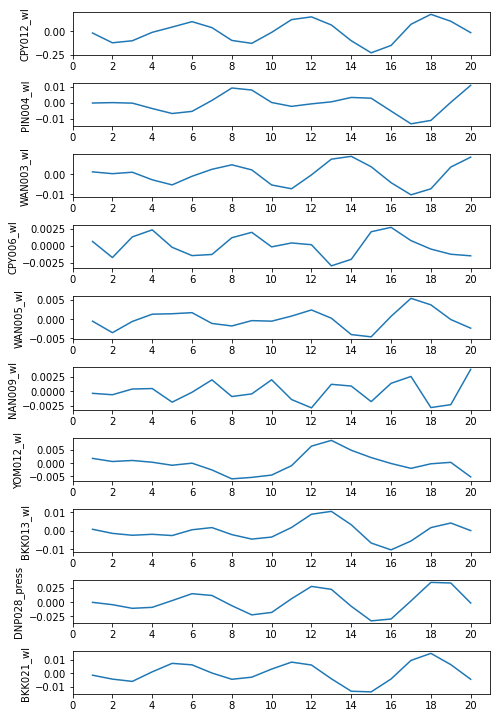

In [226]:
# Trial with manual swt

df_signal=data_mar

fig,ax = plt.subplots(df_signal.shape[1],1 ,figsize=(7,10))
ticklabel=list(np.arange(0,21,2))



for n,col in enumerate(df_signal.columns):
    print(col)
    signal = df_signal[col]
    cD=list()
    
    _lv,_corr = list(),list()
    for lv in range(20):
        if lv==0: cA=signal.values
        coeff = np.array(pywt.swt(cA,'db4',level=1))
        cD.append(coeff[0,1,:])
        cA=coeff[0,0,:]

        cD_sum = np.sum(cD,axis=0) 
        cD_sum =cD_sum.reshape(-1,df_signal.shape[0] )
        corr, _ = pearsonr(df_signal['CPY012_wl'], cD_sum[0])
        print(lv+1,'Pearsons correlation: %.3f' % corr)
        _lv.append(lv+1)
        _corr.append((corr))
    print('*'*50)
    ax[n].plot(_lv,_corr,label=col)    
    
    ax[n].set_xticks(ticklabel)
    ax[n].set_xticklabels(ticklabel)
    
    ax[n].set_ylabel(col)

plt.tight_layout()
#plt.legend(loc='lower left')
#plt.show()

# Reserve

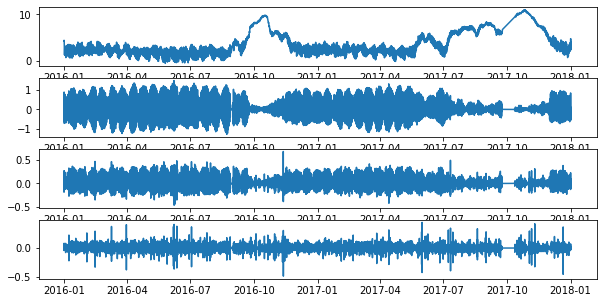

In [45]:
#std_sc = StandardScaler()
#cpy[cpy.columns] = std_sc.fit_transform(cpy[cpy.columns])

fig,ax = plt.subplots(4,1, figsize=(10,5))
for i in range(cpy.shape[1]):
    ax[i].plot(cpy.iloc[:,i])

<AxesSubplot:xlabel='date'>

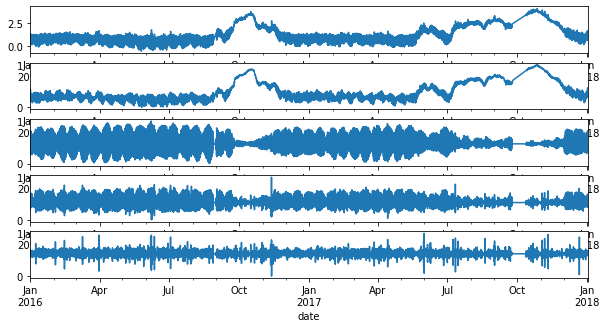

In [46]:
fig,ax = plt.subplots(5,1, figsize=(10,5))
data_mar.iloc[:,0].plot(ax=ax[0])
wdata_A3.iloc[:,0].plot(ax=ax[1])
wdata_D3.iloc[:,0].plot(ax=ax[2])
wdata_D2.iloc[:,0].plot(ax=ax[3])
wdata_D1.iloc[:,0].plot(ax=ax[4])